In [1]:
# 可视化常规导入
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [2]:
# INPUT_DIR = 'C:/ZhangLI/Codes/DataSet/m5-forecasting-accuracy'
INPUT_DIR = 'E:/Dataset/m5-forecasting-accuracy'

calendar = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
selling_prices = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')
sales_train_val = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')

sample_submission = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')

# 数据可视化
## 简单可视化
1. plot

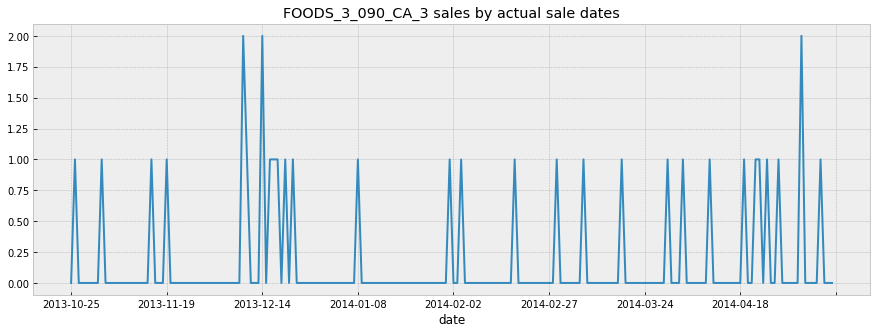

In [3]:
# set_index/ T / reset_index() / rename / merge 
d_cols = [c for c in sales_train_val.columns if 'd_' in c]
sales_train_val_new = sales_train_val.set_index('id')[d_cols].T.reset_index().rename(columns={'index':'d'}).merge(calendar, how='left', validate='1:1').set_index('date')
sales_train_val_new['HOBBIES_1_002_CA_1_validation'][1000:1200].plot(figsize=(15, 5), color=next(color_cycle), title='FOODS_3_090_CA_3 sales by actual sale dates')

# 平稳性检验 Stability test 
1. 平稳的时间序列的性质不随观测时间的变化而变化13。因此具有趋势或季节性的时间序列不是平稳时间序列——趋势和季节性使得时间序列在不同时段呈现不同性质。
2. 在判断平稳性上，下面这个例子容易让人混淆：如果一个循环变化的时间序列没有趋势和季节性，那么它仍然是平稳的。这是因为这些循环变化并没有一个固定的周期，因此在进行观测之前我们无法知道循环变化的峰值和谷值会出现在哪个位置。
## 时序图/可视化检验[]
## 分段统计均值和方差
1. 直接将序列前后拆分成2个序列，分别计算这2个序列的均值、方差，对比看是否差异明显。
## 可视化统计特征 ACF-自相关系数 PACF-偏自相关系数
1. 对于平稳的时间序列，自相关系数往往会迅速退化到零（滞后期越短相关性越高，滞后期为0时，相关性为1）；而对于非平稳的数据，退化会发生得更慢，或存在先减后增或者周期性的波动等变动。
X = [2,3,4,3,8,7]
A = [2,3,4,3,8]
B = [3,4,3,8,7]
\bar{X} = \sum{X}/6
s^2(X) = \sum{(X_i-\bar{X})^2}
r(1) = \sum{(A-\bar{X})(B-\bar{X})}
ACF(1) = r(1)/ s^2(X)

## 假设检验的方法 单位根 DF-test ADF-test PP-test DF-gls kpss
1. ADF检验 
> * 原假设 （存在单位根，时间序列是非平稳的）
> * 备择假设 （不存在单位根，时间序列是平稳的--不含截距项和趋势项平稳/含截距项平稳/含截距项和趋势平稳）

The mean of data is: 0.14, The var of data is: 0.14
The mean of data is: 0.37, The var of data is: 0.38
The mean of data is: 0.33, The var of data is: 0.44


ModuleNotFoundError: No module named 'arch'

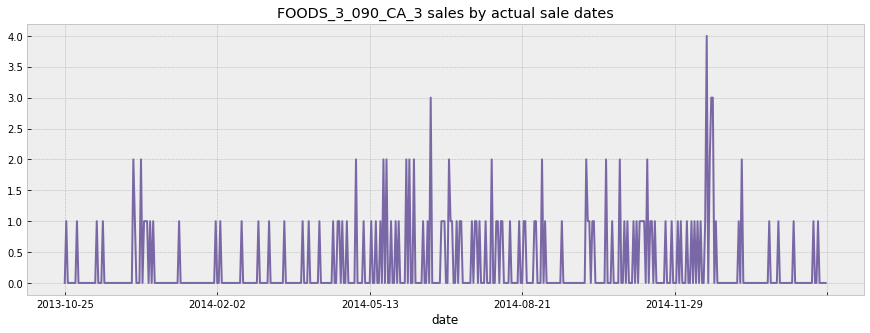

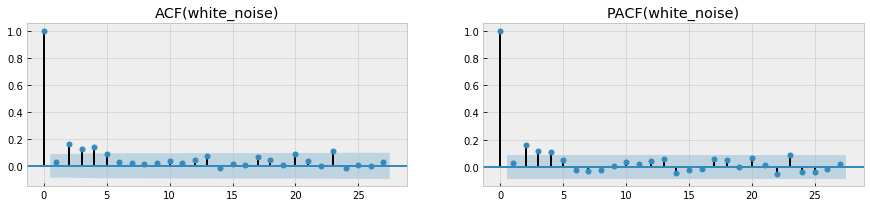

In [5]:
# 平稳性检验 Stability test 
data = sales_train_val_new['HOBBIES_1_002_CA_1_validation'][1000:1500]
# 1. 可视化数据
data.plot(figsize=(15, 5), color=next(color_cycle), title='FOODS_3_090_CA_3 sales by actual sale dates')
# 2. 可视化统计特征
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# subplots(1,2)使用ax[0] ax[1]  subplots(2,2)使用ax[0][0] ax[0][1]两位 
fig, ax = plt.subplots(1, 2, figsize=(15,3))
fig.subplots_adjust(hspace=0.5)


plot_acf(data.values, ax=ax[0])
ax[0].set_title('ACF(white_noise)')
plot_pacf(data, ax=ax[1])
ax[1].set_title('PACF(white_noise)')

# 3. 简单的统计方法 统计均值和方差
# 设计一个函数，分段取几个值
k = 3
n = int(len(data) / 3)
for i in range(k):
    # print(data[n*i:n*(i+1)])
    avg = np.mean(data[i*n:n*(i+1)])
    var = np.var(data[i*n:n*(i+1)])
    print(f'The mean of data is: {round(avg,2)}, The var of data is: {round(var,2)}',)

# 4. 假设检验
# 4.1 ADF
# arch包中ADF检验可指定trend为
# 'n'（不含截距项和时间趋势项）
# 'c'（含截距项）
# 'ct'（含截距项和时间趋势项）
# 'ctt'（含截距项和时间趋势项和二次型时间趋势项）
from arch.unitroot import ADF
adf = ADF(data)
# print(adf.pvalue)
print(adf.summary().as_text())

# 默认为 'c'
adf = ADF(data, trend='ct')
print(adf.summary().as_text())

# 4.2 PP
import numpy as np
from arch.unitroot import PhillipsPerron

pp = PhillipsPerron(data)
print(pp.summary().as_text())

pp = PhillipsPerron(data, trend = 'ct')
print(pp.summary().as_text())

# 4.3 DFGLS
import numpy as np
from arch.unitroot import DFGLS

dfgls = DFGLS(data)
print(dfgls.summary().as_text())

# 不指定trend情况下不能拒绝原假设，非平稳；指定trend='ct'时p值小于0.05，拒绝原假设，带截距项和时间趋势平稳。
dfgls = DFGLS(data, trend = 'ct')
print(dfgls.summary().as_text())

# 4.4 KPSS
# 原假设：序列不存在单位根（时间序列是平稳的或趋势平稳的）
# 备择假设：序列存在单位根（时间序列是非平稳的）
import numpy as np
from arch.unitroot import KPSS

kpss = KPSS(data)
print(kpss.summary().as_text())

kpss = KPSS(data, trend = 'ct')
print(kpss.summary().as_text())


# 白噪声检验
具有零均值同方差的独立同分布的序列为白噪声
## 自相关图
白噪声完全无自相关性，除0阶自相关系数为1外，理想情况下，延迟k阶的样本自相关系数均为0。实际上由于样本序列的有限性，延迟k阶自相关系数并不完全为0，只要在0值附近即认为无自相关性。

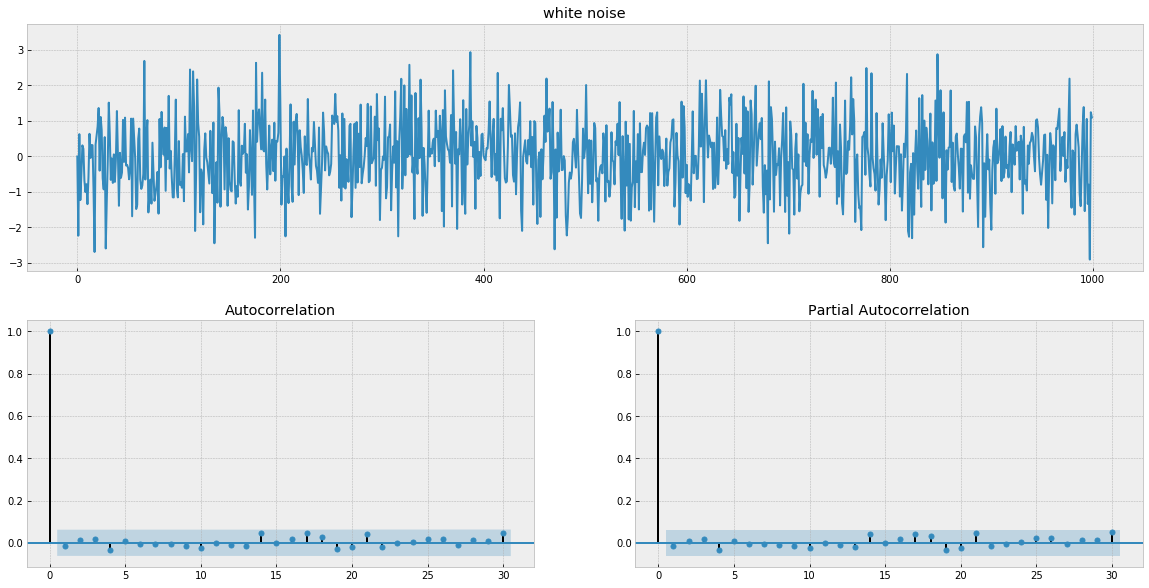

      lb_stat  lb_pvalue    bp_stat  bp_pvalue
1    0.341212   0.559130   0.339173   0.560307
2   13.425365   0.001215  13.319070   0.001282
3   21.208823   0.000095  21.025003   0.000104
4   30.547079   0.000004  30.251647   0.000004
5   34.358536   0.000002  34.009955   0.000002
6   34.731050   0.000005  34.376533   0.000006
7   34.945478   0.000011  34.587117   0.000013
8   35.045011   0.000026  34.684667   0.000031
9   35.314609   0.000052  34.948357   0.000061
10  35.930087   0.000087  35.549123   0.000101
11  36.179071   0.000158  35.791659   0.000183
12  37.262282   0.000203  36.844662   0.000237
13  39.770323   0.000151  39.277761   0.000181
14  39.900758   0.000264  39.404038   0.000316
15  40.003052   0.000453  39.502869   0.000539
16  40.032260   0.000770  39.531029   0.000911
17  42.426542   0.000582  41.834691   0.000709
18  43.392537   0.000704  42.762200   0.000865
19  43.411917   0.001138  42.780769   0.001389
20  47.165091   0.000556  46.369462   0.000717
21  47.828266

In [6]:
# 1. 一个白噪声的例子
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

white_noise = np.random.standard_normal(size=1000)

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224)

ax1.plot(white_noise)
ax1.set_title('white noise')
plot_acf(white_noise, ax=ax2)
plot_pacf(white_noise, ax=ax3)
plt.show()


# 2. 检验的方法
# 2.1 Box-Pierce检验
# 看的是特定延迟期是否存在相关性
# 滞后m阶序列值之间相互独立，序列为独立同分布的白噪声
from statsmodels.stats.diagnostic import acorr_ljungbox
res = acorr_ljungbox(data, lags=24, boxpierce=True, return_df=True)  # 各延迟阶数下的p值均小于0.05，可以拒绝原假设，序列为非白噪声
print(res)
# 2.2 Ljung-Box检验
# LB统计量小于选定置信水平下的临界值，或者p值大于显著性水平（如0.05），不能拒绝原假设，序列为白噪声
# LB统计量大于选定置信水平下的临界值，或者p值小于显著性水平（如0.05），拒绝原假设，序列非白噪声
from statsmodels.stats.diagnostic import acorr_ljungbox
res = acorr_ljungbox(data, lags=[6,12,24], return_df=True)
print(res)

# 小波变换
## 小波去噪

# 非平稳序列变成平稳序列
## 主要是怎么变回原来的序列


In [7]:
ARMA 定阶 用到p,q 

SyntaxError: invalid syntax (<ipython-input-7-e35633023185>, line 1)

# 模型预测
1. naive approach
2. Weighted Moving Average
3. Exponential Smoothing

>> fit1 forecast: 2015-03-09    0.001747
2015-03-10    0.001747
2015-03-11    0.001747
Freq: D, dtype: float64 sse: 236.8860694043509
>> fit2 forecast: 2015-03-09    0.145692
2015-03-10    0.145692
2015-03-11    0.145692
Freq: D, dtype: float64 sse: 160.77866604785117
                                    Holt Model Results                                   
Dep. Variable:     HOBBIES_1_002_CA_1_validation   No. Observations:                  500
Model:                                      Holt   SSE                            278.252
Optimized:                                 False   AIC                           -285.040
Trend:                                  Additive   BIC                           -268.182
Seasonal:                                   None   AICC                          -284.870
Seasonal Periods:                           None   Date:                 Wed, 30 Mar 2022
Box-Cox:                                   False   Time:                         16:18:24
Box-Cox Coe

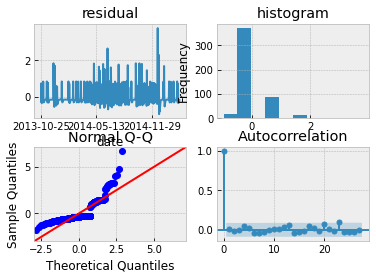

In [92]:
# 1. naive approach
def naive_approach(data, k=1):
    # 预测k个长度
    return data[-k:]
# naive_approach(data, 3)

# 2. Weighted Moving Average
def weighted_moving_average(data, k=1, w=3, method='sma'):
    # 预测k个，窗口大小为w
    # 'sma': 移动平均；'wma': 加权移动平均；'ema'：指数移动平均
    res = []
    if method == 'sma':
        for i in range(k):
            num = np.mean(list(data[-w+i:])+res[:i])
            res.append(num)
    elif method == 'wma':
        seq = np.array(range(1, w+1))
        sum_seq = np.sum(seq)
        weights = seq/sum_seq
        print(weights)
        for i in range(k):
            num = [a*b for a,b in zip(list(data[-w+i:])+res[:i], weights)]
            res.append(np.sum(num))
    elif method == 'ema':
        seq = np.array(range(1, 10+1))
        seqs = np.power(seq,2)
        sum_seq = np.sum(seqs)
        weights = seq/sum_seq
        print(weights)
        for i in range(k):
            num = [a*b for a,b in zip(list(data[-w+i:])+res[:i], weights)]
            res.append(np.sum(num))
    return res
# weighted_moving_average(data, 3, 5, 'ema')

# 3. Exponential Smoothing
# 3.1 Signal Exponential Smoothing
# 当时间序列相对平稳时，取较小的a；当时间序列波动较大时，取较大的a，以不忽略远期观测值的影响
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
# 方法1，alpha=0.7
fit1 = SimpleExpSmoothing(data).fit(smoothing_level=0.7,optimized=False)
print('>> fit1', 'forecast:', fit1.forecast(3), 'sse:', fit1.sse)

# 方法2，不加任何参数，optimized默认为True，能自动选择alpha。
fit2 = SimpleExpSmoothing(data).fit()
print('>> fit2', 'forecast:', fit2.forecast(3), 'sse:', fit2.sse)

# 3.2 Holth指数平滑
# Holt-Winters方法对当前周期性的数据拟合很好，但是需要指定周期大小，所以Holt-Winters一般适用于有明确周期性的数据。
# 实践中一般不使用乘性趋势方法，通常效果较差。另外，statoolsmodels中fit训练时，支持对数据进行box-cox变换等处理，下面代码中不再作展示
# 3.2.1 Holt线性趋势模型
from statsmodels.tsa.holtwinters import Holt
fit1 = Holt(data).fit(smoothing_level=0.7, smoothing_trend=0.2, optimized=False)
print(fit1.summary())
print('forecast:', fit1.forecast(3))
fit2 = Holt(data).fit()
print(fit2.summary())
print('forecast:', fit2.forecast(3))

# 3.2.2 Holt乘法趋势模型
from statsmodels.tsa.holtwinters import  Holt
data1 = [1,2,3,4,5,2,3,4,5,6,3,4,5,6,7]
fit1 = Holt(data1, exponential=True).fit(smoothing_level=0.7, smoothing_trend=0.2, optimized=False)  # 
print(fit1.summary())
print('>> fit1', 'forecast:', fit1.forecast(3), 'sse:', fit1.sse)

# 3.3.1 Holt-Winters加法模型
from statsmodels.tsa.holtwinters import ExponentialSmoothing
fit1 = ExponentialSmoothing(data, seasonal_periods=5, trend='add', seasonal='add').fit(smoothing_level=0.7, smoothing_trend=0.2, smoothing_seasonal=0.1, optimized=False)
print(fit1.summary())
print('forecast:', fit1.forecast(3))

# 3.3.2 Holt-Winters乘法模型
fit1 = ExponentialSmoothing(data1, seasonal_periods=5, trend='add', seasonal='mul').fit(smoothing_level=0.7, smoothing_trend=0.2, smoothing_seasonal=0.1, optimized=False)
print(fit1.summary())
print('forecast:', fit1.forecast(3))

# 3.3.3 Holt-Winters的衰减法

fit1 = ExponentialSmoothing(data1, seasonal_periods=5, trend='add', seasonal='mul', damped_trend=True).fit(smoothing_level=0.7, smoothing_trend=0.2, smoothing_seasonal=0.1, optimized=True)
print(fit1.summary())
print('forecast:', fit1.forecast(3))

# 4. ARMA
# 4.1 平稳性检验 -> 白噪声检测 -> 定阶 p,q -> 模型训练 -> 残差分布 -> 模型预测 
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import arma_order_select_ic
bic_min_order = arma_order_select_ic(data, max_ar=5, max_ma=5, ic='bic')['bic_min_order']
print(bic_min_order)
# 模型训练
from statsmodels.tsa.arima_model import ARMA
model = ARMA(data, order=bic_min_order).fit(disp=-1)
print(model.summary())
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.3)
model.resid.plot(ax=axs[0][0])
axs[0][0].set_title('residual')
model.resid.plot(kind='hist', ax=axs[0][1])
axs[0][1].set_title('histogram')
sm.qqplot(model.resid, line='45', fit=True, ax=axs[1][0])
axs[1][0].set_title('Normal Q-Q')
plot_acf(model.resid, ax=axs[1][1])
plt.show()

# 4.2 ARIMA

# 4.3 SARIMA


In [10]:
data

date
2013-10-25    0
2013-10-26    1
2013-10-27    0
2013-10-28    0
2013-10-29    0
             ..
2015-03-04    0
2015-03-05    0
2015-03-06    0
2015-03-07    0
2015-03-08    0
Name: HOBBIES_1_002_CA_1_validation, Length: 500, dtype: int64